In [45]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import time
from sklearn.neighbors import KNeighborsClassifier






--Train Images--
Num of All Images:  950
Num of Beds Images:  190
Num of chairs Images:  190
Num of nightstands Images:  190
Num of sofas Images:  190
Num of tables Images:  190
--Test Images--
Num of Images:  50


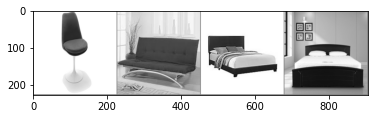

GroundTruth:  chair  sofa   bed   bed
Pridicted:  chair table   bed table
Accuracy of the network on the 423 test images: 64 %

Tensor to np
[[-0.33682495 -0.19045857 -0.05011752  0.59917718 -0.1194207 ]
 [-0.24526379 -0.53552878 -0.04995195  0.25360477  0.425282  ]
 [-0.72930503  0.49961877  0.01479844 -0.03597879  0.29476765]
 [-0.61266363  0.01457562 -0.25184911 -0.06128217  0.69663537]]
tensor([[-0.3368, -0.1905, -0.0501,  0.5992, -0.1194],
        [-0.2453, -0.5355, -0.0500,  0.2536,  0.4253],
        [-0.7293,  0.4996,  0.0148, -0.0360,  0.2948],
        [-0.6127,  0.0146, -0.2518, -0.0613,  0.6966]], dtype=torch.float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [60]:

# train_location = './drive/MyDrive/data/img/train/'
# test_location = './drive/MyDrive/data/img/val/'

train_location = './drive/MyDrive/data/Furniture/train/'
test_location = './drive/MyDrive/data/Furniture/val/'

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=3,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, kernel_size=3,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 
        self.fc = torch.nn.Linear(50176, 5, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

class FurnitureDataset():
    def __init__(self, image, class_to_int, mode, transforms):
        super().__init__()
        self.image = image
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, index):
        image_name = self.image[index]
        image = Image.open(train_location + image_name)
        image = image.resize((224,224))

        if self.mode == 'train' :
            #레이블 입력
            label = self.class_to_int[image_name.split('.')[0]]
            label = torch.tensor(label,dtype=torch.long)
            #이미지 변형 적용
            image = self.transforms(image)
            return image, label
        elif self.mode == 'test':
          #레이블 입력
            label = self.class_to_int[image_name.split('.')[0]]
            label = torch.tensor(label,dtype=torch.long)
            #이미지 변형 적용용
            image = self.transforms(image)
            return image, label

    def __len__(self):
        return len(self.image)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

if __name__ == '__main__':
    #데이터 셋 불러오고 정규화
    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor(),
          transforms.Normalize((0.5),(0.5))
          ]
    )

    train_images = os.listdir(train_location)
    test_images = os.listdir(test_location)
    print("--Train Images--")
    print("Num of All Images: ", len(train_images))

    beds_list = [img for img in train_images if img.split(".")[0] == "bed"]
    chairs_list = [img for img in train_images if img.split(".")[0] == "chair"]
    nightstands_list = [img for img in train_images if img.split(".")[0] == "nightstand"]
    sofas_list = [img for img in train_images if img.split(".")[0] == "sofa"]
    tables_list = [img for img in train_images if img.split(".")[0] == "table"]
    print("Num of Beds Images: ", len(beds_list))
    print("Num of chairs Images: ", len(chairs_list))
    print("Num of nightstands Images: ", len(nightstands_list))
    print("Num of sofas Images: ", len(sofas_list))
    print("Num of tables Images: ", len(tables_list))
    print("--Test Images--")
    print("Num of Images: ", len(test_images))

    # 레이블 구분
    class_to_int = {"bed": 0, "chair": 1, "nightstand": 2, "sofa": 3, "table": 4}
    int_to_class = {0: "bed", 1: "chair", 2: "nightstand", 3: "sofa", 4: "table"}
    classes = ['bed', 'chair', 'nightstand', 'sofa', 'table']

    # 데이터 셋 생성
    train_dataset = FurnitureDataset(train_images, class_to_int, mode='train', transforms=transform)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

    test_dataset = FurnitureDataset(test_images, class_to_int, mode='test', transforms=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

    ## 로드할때 여기부터 test전까지 주석처리 ( PATH 정의 빼고)
    #net = CNN()

    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    #device = 'cuda'
    #device = 'cuda' if torch.cuda.is_available() else 'cpu'
    #print (device,"로 학습")

    # 신경망 학습하기
    #for epoch in range(2):
    #    running_loss = 0.0
    #    for i, data in enumerate(trainloader,0):
    #        inputs, labels = data  # data입력
    #        optimizer.zero_grad()  # gradient 매개변수를 0으로 만듬
            # 순전파 + 역전파 + 최적화
    #        outputs = net(inputs)
    #        loss = criterion(outputs, labels)
    #        loss.backward()
    #        optimizer.step()
           # 통계출력
    #        running_loss += loss.item()
    #        if i % 200 == 199:
    #            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
    #            running_loss = 0.0
    #print('Finished Training')
    PATH = './cifar_net.pth'
    #torch.save(net, PATH)
 
  
#############################################test########################################
    #시험용 데이터로 신경망 검사하기
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    #이미지 출력
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    
    #net.load_state_dict(torch.load(PATH))
    #로드할때 윗줄 주석처리하고 밑 두줄 주석제거
    net = torch.load(PATH)
    net.eval()
    outputs = net(images)
    _, predicted =torch.max(outputs, 1)
    print('Pridicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
    # 전체 데이터 셋에 대한 결과 확인
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 423 test images: %d %%' % (100*correct/total))

    #tensor -> np (train)
    print("\nTensor to np")
    X = np.empty((0, 4), dtype=int)
    Y = np.empty((0,4),dtype=int)
    for data in trainloader:
      images, labels = data
      outputs = net(images)
      X = np.append(X,outputs.detach().numpy())
      Y = np.append(Y,labels.numpy())
    X = np.reshape(X,(950,5)) #950개 5개tensor
    Y = np.reshape(Y,(950,1)) #950개 1개label

    #np knn
    reg = KNeighborsClassifier(n_neighbors=4)
    reg.fit(X,Y)
    l = reg.kneighbors([[0,0,0,0,0]],n_neighbors=4,return_distance=False) #이미지 입력부분 (np)
    for i in l:
      temp = np.empty((0,4),dtype=int)
      temp = np.append(temp, X[i])
    temp = np.reshape(temp,(4,5)) #4개 5개tensor(np)
    print(temp) #가장 가까운 이미지 4개 출력(np)

    #np -> tensor 
    result = torch.tensor(temp)
    print(result)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
